# Capstone Final Project
### Identify candidate locations for new accommodation venue in Ljubljana, Slovenia 

## Table of contents
* [Business Problem](#business_problem)
* [Data](#data)
* [Methodology](#methodology)
* [Data collection and preparation](#collection)
* [Analysis](#analysis)

## Business Problem <a name="business_problem"></a>

The city of Ljubljana, capital of Slovenia, has been a very popular tourist destination in the recent  years and it hosts more tourists each year. Also more and more tourists decide to stay in Ljubljana for more than 1 day.  Thus the accommodation offering (hotels, motels, inns, bed & breakfasts etc. ) needs to grow with the demand.  

One of the most important factors when looking for a location for tourist accommodation is location. The goal of this project is to identify parts of the city of Ljubljana that could be candidates for location for tourist acommodation. 

The report is targeting investors/stakeholders/contractors that are interested in creating new accommodation offerings in Ljubljana. The results should be interesting for either small sized (butique) acommodations as well as higher capacity accommodation.  

There are other factors that impact the decision which are not considered in this project, like realestate prices. 

## Data <a name="data"></a>

The following assumptions will be considered when trying to find a location candidate:
* No other tourist accommodation venue in vicinity. 
* Gravitating towards the city center. Most of Ljubljana's attractions are in the city center. 
* Close to existing food & drink venues. 
* Close to public transportation grid.

The main  datasource will be Foursquare database for the following information:
* Location of existing accommodation venues (any subtype) in an area. 
* Location of existing food venues (any subtype) in an area.
* Location of existing bus stations/stops in an area. 

Transformations between addresses and geographic locations will be done using the Nomatim API. 

All geographic coordinates calculations will be done in WGS84 geodetic system using Pyproj API.

Locations of administrative regions (neighbourhoods/boroughs/districts) could be used as source points for Foursquare requests. However those regions have incorrect shapes and very different sizes which can create gaps in the data if not careful. To avoid such search gaps it was decided to place a square grid over the city of Ljubljana, spanning several kilometers and centered at the most popular tourist spot, "Ljubljansko tromostovje".
Each grid unit/area will be used as a bounding box for retrieving venues from Foursquare using the search API.


## Methodology <a name="methodology"></a>

The goal of this project is to finds part of the city of Ljubljana that have low accomodation density. At the same time those candidate areas need to be near to the public transportation grid and food venues

In the first steps we collect and prepare the venue information from Foursquare data for an area that spans several kilometers. To ease the data collection we will create a square grid and each grid unit (area) will represent the bounds for Foursquare search. 
Each venue (hotel, bus station, food place) has a location and category.

In the second step we will explore the collected data using visualizations. We will then create a finer grid that will represent accommodation location candidates and calculate various metrics, like distance to nearest bus stop or food venue for each location candidate, number of bus stops or food venues near the location candidate. The following assumptions will be used:
* No other accommodation object within the walking distance from the location candidate.
* At least one bus station within the walking distance from the location candidate.
* At least 3 food venues within the walking distance from the location candidate.
* Focusing on the area around the city center, up to 3.5 km in radius. 

We define walking distance as a distance up to 400 meters. This corresponds to a 5 minute walk (80 meters for 1 minute of walking time). 

In the final section we will use k-means clustering method to find blobs of locations that meet the predefined requirements. The cluster centers can be used as starting addresses for further investigation of the location candidates 


## Data collection <a name="collection"></a>

In [2]:
# imports

# uncomment to install a package with either conda or pip if needed.
# !pip install geopy
# !conda install -c conda-forge geopy --yes 

from geopy.geocoders import Nominatim 
from geopy.extra.rate_limiter import RateLimiter

import folium

import requests 
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import pyproj

import math
import time

In [3]:
# foursquare credentials
foursquare_client_id = 'EXENEWRKIY0ZQPXVOZCD3RWEXTNNQC1113GGBXYXJVHERV0J' # your Foursquare ID
foursquare_client_secret = 'YHAQNOL1EMK0BHONYERC4J52J4ECBPAIQOKWSULTVWZZUQKM' # your Foursquare Secret
foursquare_version = '20180605' # Foursquare API version
foursquare_limit = 100

Nomatim API is used for transforming geographic coordinates in WGS84 coordinate system to addresses and vice versa. We will use a 5 second delay for each invocation to limit the rate of requests. 

In [4]:
# helper methods for geographic coordinates <-> address transformation
geolocator = Nominatim(user_agent="LJ_explorer")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=5)
reverse= RateLimiter(geolocator.reverse, min_delay_seconds=5)

def get_address_from_coordinates(lat, lon):
    address = reverse((lat,lon), exactly_one=True, language="si")
    return address.address.split(', Ljubljana')[0]

def get_coordinates_from_address(address):
    location = geocode(address)
    return location.latitude,location.longitude



In [5]:
# Helper methods for calculating various geographic coordinates in WGS84 space 

geod = pyproj.Geod(ellps='WGS84')

# calculate the geo point which is distance away in the direction of the fwd_azimuth
def calculate_geo_point(start_lat, start_lon, fwd_azimuth, distance):
    end_lon, end_lat, back_azimuth = geod.fwd(start_lon,start_lat,fwd_azimuth,distance)
    return (end_lat, end_lon)

# calculates geo coordinates of corners of a square. Start_lat and start_lon assumes SW corner.
def calculate_square_corners(start_lat, start_lon, square_size):
    corners = [] # clock wise - sw, nw, ne, sw
    corners.append((start_lat, start_lon))
    corners.append(calculate_geo_point(start_lat, start_lon, 0, square_size))
    corners.append(calculate_geo_point(start_lat, start_lon, 45, math.sqrt(2)*square_size))
    corners.append(calculate_geo_point(start_lat, start_lon, 90, square_size))
    return corners

# calculate center coordinates of a square, assumes SW corner
def calculate_square_center(start_lat, start_lon, square_size):
    return calculate_geo_point(start_lat, start_lon, 45, math.sqrt(2)*square_size/2 )

# calculate distance between 2 geo coordinates 
def calculate_distance(start_lat, start_lon, end_lat, end_lon):
    a1, a1, distance = geod.inv(start_lon, start_lat, end_lon, end_lat)
    return distance

Let's find the geographic coordinates of the one of the most famous Ljubljana's tourist landmark which is located in the city center.

In [6]:
# Get the Ljubljana tourist center point.

lj_center_address = 'Prešernov trg, Ljubljana, Slovenia'

lj_center_lat, lj_center_lon = get_coordinates_from_address(lj_center_address)
lj_center_coordinates=(lj_center_lat,lj_center_lon)

print('Coordinates of {} = {}'.format(lj_center_address, lj_center_coordinates))

Coordinates of Prešernov trg, Ljubljana, Slovenia = (46.05140755, 14.506095911950972)


Now we can create a grid that is centered at the tourist center point above. In the generated grid the individual areas will be used as bounding boxes for the Foursquare search API. So let's create a grid that spans 10km and the sides of each area will be 1km in length, and show it on a map.

In [7]:
# Helper method to generate a grid, a square defined by coordinates of the sw corner, grid size and grid unit.
# Each grid unit (=area) is a square defined by coordinates of it's corners [sw, nw, ne, se]. 
# Each corner is (latitude, longitude) pair.

def generate_grid(start_lat, start_lon, grid_size, grid_unit):

    #  start at the SW corner (start_lat, start_lon) of the grid and make your way up 
    grid=[]
    row_origin = (start_lat, start_lon) 
    
    for i in range(0, math.floor(grid_size/grid_unit)):
        col_origin = row_origin # remember the origin
        for j in range(0, math.floor(grid_size/grid_unit)):
            square = calculate_square_corners(col_origin[0], col_origin[1], grid_unit)
            grid.append(square)
            col_origin = square[3] # new SW corner is the SE corner of the previous square
        
        # new row_origin is the sw corner of the most left area one row above
        row_origin = calculate_geo_point(row_origin[0], row_origin[1], 0, grid_unit) 
    
    return grid



In [8]:
# Grid parameters
grid_size = 10000 # meters
grid_unit = 1000 # meters 

# Get the grid's SW corner starting from the Ljubljana center
grid_sw_corner = calculate_geo_point(lj_center_lat, lj_center_lon, 225, grid_size*math.sqrt(2)/2)

grid = generate_grid(grid_sw_corner[0], grid_sw_corner[1], grid_size, grid_unit)

print("Number of grid areas:", len(grid))
print("Corner coordinates of the first area:", grid[0])

Number of grid areas: 100
Corner coordinates of the first area: [(46.0064058166316, 14.44154176579499), (46.01540254376851, 14.44154176579499), (46.015401814379786, 14.45445468825389), (46.00640508739683, 14.454452594821426)]


In [9]:
# Display the grid on the map of Ljubljana together with the center point
map_lj= folium.Map(location=lj_center_coordinates, zoom_start=12)
folium.Marker(lj_center_coordinates, popup=lj_center_address).add_to(map_lj)

for square in grid:
    folium.Rectangle(square, weight=0.7).add_to(map_lj)

map_lj

We have a grid that covers most of Ljubljana. We can now poll the Foursquare API for data about existing accommodation venues, bus stations/stops and food venues.

In [10]:
# Helper functions for sending a request to the Foursquare API and getting the JSON results. 

radius = 250 # meters

# requires category_id, coordinates of sw corner, coordinates of ne corner
def search_venues_in_area(sw_lat, sw_lon, ne_lat, ne_lon, category_id, client_id, client_secret, version, limit):
    
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&intent=browse&sw={},{}&ne={},{}&categoryId={}&limit={}'.format(
        client_id, 
        client_secret, 
        version,
        sw_lat,
        sw_lon,
        ne_lat,
        ne_lon,
        category_id,    
        limit)
    
    try:
        r = requests.get(url)
        r.raise_for_status()
        return r.json()['response']['venues']
        
    except requests.exceptions.HTTPError as err:
        print(err.response.text)
        return None
    
    
def search_venues_in_radius(lat, lon, category_id, radius, client_id, client_secret, version, limit):
    
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&intent=browse&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, 
        client_secret, 
        version,
        lat,
        lon,
        category_id,
        radius,
        limit)
    
    try:
        r = requests.get(url)
        r.raise_for_status()
        return r.json()['response']['groups'][0]['items'] 
        
    except requests.exceptions.HTTPError as err:
        print(err.response.text)
        return None

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']



In [11]:
# Helper method to get venues from all grid areas, limit by category ids, ignore duplicates
# The result is a DataFrame of all collected venues (Name, Category, Latitude, Longitude, Area, Distance to center)

def get_venues_in_grid(categories, grid):
    frames = []
    print("Processing areas: ",end="")
    counter = 0
    
    for area in grid:
        
        for category_id in categories:
            time.sleep(1)
            
            venues_in_area = search_venues_in_area(area[0][0],
                                                   area[0][1],
                                                   area[2][0],
                                                   area[2][1],
                                                   category_id,
                                                   foursquare_client_id,
                                                   foursquare_client_secret,
                                                   foursquare_version,
                                                   foursquare_limit)
    
            # Check if something went wrong
            if venues_in_area == None:
                print("Search not working...")
                break
        
            # if nothing is found skip to the next area
            if len(venues_in_area) == 0:
                print(".",end="")
                continue
    
            # clean up and generate a panda frame, add to the frames list
            print("+",end="")
            venues_in_area = json_normalize(venues_in_area)
            filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
            venues_in_area = venues_in_area.loc[:, filtered_columns]
            venues_in_area['categories'] = venues_in_area.apply(get_category_type, axis=1)
            venues_in_area.columns = ['Name', 'Category', 'Latitude', 'Longitude']
            venues_in_area['Area'] = counter
            
            frames.append(venues_in_area)
            ###
        
        counter = counter + 1
        
    # combine results into one frame
    venues = pd.concat(frames, ignore_index=True)

    # remove duplicates (based on venue name) and reset the index
    venues.drop_duplicates(subset ="Name", keep = False, inplace = True)
    venues.reset_index(drop=True, inplace=True)
    
    # add a column for Distance to city center
    venues['Distance to center'] = venues.apply(lambda x: 
                                        calculate_distance(
                                            lj_center_lat, lj_center_lon, 
                                            x["Latitude"], x["Longitude"]), axis=1)
    
    return venues


In [12]:
# Get all the accomodation venues in the grid. 
# from_file defines whether the data is pulled from the web or from an existing file. 

# Foursqure category list
# https://developer.foursquare.com/docs/resources/categories

# Accomodations_id is the Foursquare category id for "Hotel"
accommodations_id = ["4bf58dd8d48988d1fa931735"]
from_file = True

if (from_file):
    try:
        print("Reading data from file...", end="")
        accommodations = pd.read_csv("accommodations_10km.csv")
        print("Done")
    except:
        print("Can't load data from file.")

else:
    try:
        accommodations = get_venues_in_grid(accommodations_id, grid)
        accommodations.to_csv("accommodations_10km.csv", index=False)
    except:
        print("Problem fetching or saving data.")


Reading data from file...Done


In [13]:
accommodations.head()

,Name,Category,Latitude,Longitude,Area,Distance to center
0,By The Way,Bed & Breakfast,46.031424,14.445213,20,5209.900213
1,AHOTEL Hotel Ljubljana,Hotel,46.030272,14.491635,23,2602.324674
2,Roomsforyoung,Hostel,46.042152,14.453954,30,4164.743071
3,Apartmaji Dolgi Most,Vacation Rental,46.037556,14.459239,31,3940.051107
4,Swiss Diamond Hotel,Hotel,46.036586,14.475757,32,2868.589601


In [14]:
# Get all the bus stations in the grid
# from_file defines whether the data is pulled from the web or from an existing file. 

bus_station_id = ["4bf58dd8d48988d1fe931735", "52f2ab2ebcbc57f1066b8b4f"]

from_file = True

if (from_file):
    try:
        print("Reading data from file...", end="")
        bus_stations = pd.read_csv("busstations_10km.csv")
        print("Done.")
    except:
        print("Can't load data from file.")

else:
    try:
        bus_stations = get_venues_in_grid(bus_station_id, grid)
        bus_stations.to_csv("busstations_10km.csv", index=False)
    except:
        print("Problem fetching or saving data.")



Reading data from file...Done.


In [15]:
bus_stations.head()

,Name,Category,Latitude,Longitude,Area,Distance to center
0,LPP postajališče Barje,Bus Stop,46.013611,14.511415,5,4221.287749
1,LPP postajališče Spodnji Rudnik,Bus Line,46.023627,14.540105,17,4057.818163
2,LPP Postajališče NS Rudnik,Bus Stop,46.020218,14.535108,17,4130.698456
3,Lpp Postajališče Na Gmajnici,Bus Station,46.030425,14.442337,20,5458.678355
4,LPP postajališče Cesta v Gorice,Bus Stop,46.032295,14.465184,21,3813.342718


In [16]:
# Get all the food venues in the grid.
# from_file defines whether the data is pulled from the web or from an existing file. 

food_id = ["4d4b7105d754a06374d81259"]

from_file = True

if (from_file):
    try:
        print("Reading data from file...", end="")
        food_venues = pd.read_csv("foodvenues_10km.csv")
        print("Done")
    except:
        print("Can't load data from file.")

else:
    try:
        food_venues = get_venues_in_grid(food_id, grid)
        food_venues.to_csv("foodvenues_10km.csv",index=False)
    except:
        print("Problem fetching or saving data.")
        



Reading data from file...Done


In [17]:
food_venues.head()

,Name,Category,Latitude,Longitude,Area,Distance to center
0,Kitajski Zmaj,Chinese Restaurant,46.013634,14.511406,5,4218.706161
1,Kava-linčk,Café,46.008799,14.544174,7,5578.617075
2,Cavallino caffe,Café,46.008836,14.544482,7,5587.741561
3,Gostilnica Orle,Eastern European Restaurant,46.014998,14.570146,9,6400.478086
4,Gostilna Vrbinc,Restaurant,46.021559,14.523250,16,3573.646557


## Analysis <a name="analysis"></a>

Now we have all the accommodation venues, bus stations and food venues in spanning the area of 10km centered around the tourist center of Ljubljana. 

In [18]:
print("Total number of accommodations in the grid:", len(accommodations))
print("Total number of bus stations in the grid:", len(bus_stations))
print("Total number of food venues in the grid:", len(food_venues))

Total number of accommodations in the grid: 189
Total number of bus stations in the grid: 206
Total number of food venues in the grid: 798


Let's see all these venues on a map.

In [19]:
# Visualize accomodations, bus stations and food venues on a map

map_lj= folium.Map(location=lj_center_coordinates, zoom_start=12)
folium.Marker(lj_center_coordinates, popup=lj_center_address).add_to(map_lj)
folium.TileLayer('cartodbpositron').add_to(map_lj)

for square in grid:
    folium.Rectangle(square, weight=0.6).add_to(map_lj)

##  
 
    
for lat, lon, name in zip(food_venues['Latitude'], food_venues['Longitude'], food_venues['Name']):
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.3,
        parse_html=False).add_to(map_lj)  
    
for lat, lon, name in zip(bus_stations['Latitude'], bus_stations['Longitude'], bus_stations['Name']):
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.3,
        parse_html=False).add_to(map_lj)  

for lat, lon in zip(accommodations['Latitude'], accommodations['Longitude']):    
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.3,
        parse_html=False).add_to(map_lj) 
map_lj

Even now we see that the accommodation venues grouping around the city center but the image is quite crowded. A heat map of the accommodation density should showcase this better.

In [20]:
# Heatmap of accommodation density 

from folium import plugins
from folium.plugins import HeatMap

accommodation_coordinates = zip(accommodations['Latitude'], accommodations['Longitude'])

map_lj= folium.Map(location=lj_center_coordinates, zoom_start=13)
#folium.TileLayer('cartodbpositron').add_to(map_lj)
folium.Marker(lj_center_coordinates, popup=lj_center_address).add_to(map_lj)
HeatMap(accommodation_coordinates, radius = 25).add_to(map_lj)

for lat, lon, name in zip(accommodations['Latitude'], accommodations['Longitude'], accommodations['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)  
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color='white',
        popup=label,
        fill=True,
        fill_color='white',
        fill_opacity=0.3,
        parse_html=False).add_to(map_lj)  
    
for square in grid:
    folium.Rectangle(square, weight=0.7).add_to(map_lj)
    


map_lj

Let's see how the accommodation density changes with distance to city center. 

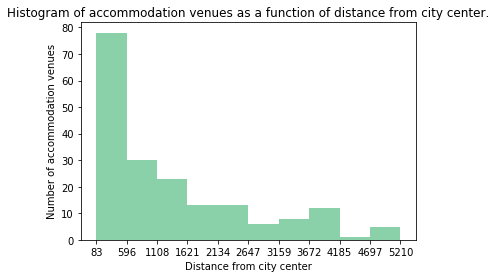

In [21]:
# Histogram of accomodiation venues based on distance
#bins = np.linspace(min(accommodations['Distance to center']), max(accommodations['Distance to center']), 10)
#accommodations["Distance to center binned"]=pd.cut(accommodations["Distance to center"], bins, include_lowest=True)


count,bin_edges = np.histogram(accommodations['Distance to center'],10)

accommodations['Distance to center'].plot(kind='hist',
                                          xticks=bin_edges,
                                          bins=10,
                                          alpha=0.6,
                                          color=['mediumseagreen'])
plt.title("Histogram of accommodation venues as a function of distance from city center.")
plt.ylabel("Number of accommodation venues")
plt.xlabel("Distance from city center")
plt.show()

In [22]:
print(count)

[78 30 23 13 13  6  8 12  1  5]


Here we see that 78 accommodation objects (almost half of all) are in the radius of 600 meters from city center. 
We expect that the candidate locations will be mostly outside of the 2km radius. 

Let's see the breakdown of accommodation categories.

In [54]:
accommodations.groupby(['Category']).count()

,Name,Latitude,Longitude,Area,Distance to center
Category,,,,,
Bed & Breakfast,27,27,27,27,27
Boarding House,7,7,7,7,7
Hostel,50,50,50,50,50
Hotel,79,79,79,79,79
Hotel Pool,1,1,1,1,1
Inn,1,1,1,1,1
Motel,2,2,2,2,2
Pizza Place,1,1,1,1,1
Pub,2,2,2,2,2


Here we see that the most accommodation venues are hotels and hostels, which are likely high capacity and suitable for traveling groups. 

So the existing accommodation venues group mostly around the city center. This is expected as most of the tourist attractions are focused in the city center which is the old and historic Ljubljana.
There are also clusters of accommodations stretched along the main roads around and inbound to Ljubljana.
But we see there are obvious pockets where a new accommodation venue could be established.

Let's generate candidate locations for the new accommodation venue. For this we will create a finer grid within each area of the existing grid. In this case each area will be split into 100 meter sections. 
The idea here is to create location candidates as the the geographic locations of the center of each subarea. 

In [27]:
walking_distance = 400 # meters, this corresponds to 5 minutes of walking.
subgrid_unit = 100 # meters, this corresponds to a good minute of walking.

In [28]:
# ATTENTION, if load data from file then skip to cell with "locations.describe()"
# If from_file = False, the data will be calculated. 

from_file = True

if (from_file):
    try:
        print("Reading data from file...", end="")
        locations = pd.read_csv("location_candidates_10k.csv")
        print("Done")
    except:
        print("Can't load data from file.")

Reading data from file...Done


In [29]:
# Within each grid area create a finer grid and calculate square centers of each subgrid square. 
# This will represent the accommodation location candidates.

location_candidates = []
for area in grid:
    subgrid = generate_grid(area[0][0], area[0][1], grid_unit, subgrid_unit)
    for subarea in subgrid:
        subarea_center = calculate_square_center(subarea[0][0], subarea[0][1], subgrid_unit)
        location_candidates.append(subarea_center)


In [25]:
# create a Dataframe of location candidates

locations = pd.DataFrame(location_candidates, columns = ['Latitude', 'Longitude'])
print("Number of location candidates before filtering:", len(locations))
locations.head()

Number of location candidates before filtering: 10000


,Latitude,Longitude
0,46.006856,14.442187
1,46.006856,14.443478
2,46.006856,14.444769
3,46.006856,14.446061
4,46.006856,14.447352


With the location candidates created, for each location we collect the data from the DataFrames we created from Foursquare - the number of and nearest accommodation, bus station and food venue. 

In [29]:
# For each accommodation get the number of other accommodation in walking distance and nearest accommodation

def get_number_of_nearby_accommodation(row, radius=walking_distance):
    count = 0
    for lat, lon in zip(accommodations['Latitude'], accommodations['Longitude']):
        dist = calculate_distance(row["Latitude"], row["Longitude"], lat, lon)
        if dist > 0 and dist < radius:
            count = count + 1
    return count
###          
    
def get_distance_to_nearest_accommodation(row):
    min_distance = 100000
    for lat, lon in zip(accommodations['Latitude'], accommodations['Longitude']):
        dist = calculate_distance(row["Latitude"], row["Longitude"], lat, lon)
        
        if dist > 0 and dist < min_distance:
            min_distance = dist
    return min_distance
###

locations['Number of nearby accommodation'] = locations.apply(lambda x: get_number_of_nearby_accommodation(x), axis=1)
locations['Distance to nearest accommodation'] = locations.apply(lambda x: get_distance_to_nearest_accommodation(x), axis=1) 




In [30]:
locations.head()

,Latitude,Longitude,Number of nearby accommodation,Distance to nearest accommodation
0,46.006856,14.442187,0,2740.846298
1,46.006856,14.443478,0,2734.115806
2,46.006856,14.444769,0,2731.031101
3,46.006856,14.446061,0,2731.604534
4,46.006856,14.447352,0,2735.833804


In [31]:
# For each accommodation get the number of bus stations in walking distance and nearest bus station

def get_number_of_nearby_bus_stations(row, radius=walking_distance):
    count = 0
    for lat, lon in zip(bus_stations['Latitude'], bus_stations['Longitude']):
        dist = calculate_distance(row["Latitude"], row["Longitude"], lat, lon)
        if dist > 0 and dist < radius:
            count = count + 1
    return count
###

def get_distance_to_nearest_bus_station(row):
    min_distance = 100000
    for lat, lon in zip(bus_stations['Latitude'], bus_stations['Longitude']):
        dist = calculate_distance(row["Latitude"], row["Longitude"], lat, lon)
        
        if dist > 0 and dist < min_distance:
            min_distance = dist
    return min_distance
###

locations['Number of nearby bus stations'] = locations.apply(lambda x: get_number_of_nearby_bus_stations(x), axis=1)          
locations['Distance to nearest bus station'] = locations.apply(lambda x: get_distance_to_nearest_bus_station(x), axis=1) 


In [30]:
locations.head()

,Latitude,Longitude,Number of nearby accommodation,Distance to nearest accommodation,Number of nearby bus stations,Distance to nearest bus station,Number of nearby food venues,Distance to nearest food venue,Distance to center
0,46.006856,14.442187,0,2740.846298,0,2619.804258,0,2719.359009,7000.357157
1,46.006856,14.443478,0,2734.115806,0,2621.271032,0,2715.496240,6930.065753
2,46.006856,14.444769,0,2731.031101,0,2626.545350,0,2715.311605,6860.510620
3,46.006856,14.446061,0,2731.604534,0,2635.604353,0,2717.382964,6791.714379
4,46.006856,14.447352,0,2735.833804,0,2648.409205,0,2709.688064,6723.700324


In [33]:
# For each accommodation get the number of food venues in walking distance and nearest food venue
def get_number_of_nearby_food_venues(row, radius = walking_distance):
    count = 0
    for lat, lon in zip(food_venues['Latitude'], food_venues['Longitude']):
        dist = calculate_distance(row["Latitude"], row["Longitude"], lat, lon)
        if dist > 0 and dist <= radius:
            count = count + 1
    return count
###         
    
def get_distance_to_nearest_food_venue(row):
    min_distance = 100000
    for lat, lon in zip(food_venues['Latitude'], food_venues['Longitude']):
        dist = calculate_distance(row["Latitude"], row["Longitude"], lat, lon)
        
        if dist > 0 and dist < min_distance:
            min_distance = dist
    return min_distance
###

locations['Number of nearby food venues'] = locations.apply(lambda x: get_number_of_nearby_food_venues(x), axis=1) 
locations['Distance to nearest food venue'] = locations.apply(lambda x: get_distance_to_nearest_food_venue(x), axis=1) 



In [34]:
# calculate the location distance to the city center:

locations['Distance to center'] = locations.apply(lambda x: 
                                        calculate_distance(
                                            lj_center_lat, lj_center_lon, 
                                            x["Latitude"], x["Longitude"]), axis=1)

In [35]:
locations.head()

,Latitude,Longitude,Number of nearby accommodation,Distance to nearest accommodation,Number of nearby bus stations,Distance to nearest bus station,Number of nearby food venues,Distance to nearest food venue,Distance to center
0,46.006856,14.442187,0,2740.846298,0,2619.804258,0,2719.359009,7000.357157
1,46.006856,14.443478,0,2734.115806,0,2621.271032,0,2715.496240,6930.065753
2,46.006856,14.444769,0,2731.031101,0,2626.545350,0,2715.311605,6860.510620
3,46.006856,14.446061,0,2731.604534,0,2635.604353,0,2717.382964,6791.714379
4,46.006856,14.447352,0,2735.833804,0,2648.409205,0,2709.688064,6723.700324


In [38]:
# save the data 
locations.to_csv("location_candidates_10k.csv", index=False)

In [31]:
locations.describe()

,Latitude,Longitude,Number of nearby accommodation,Distance to nearest accommodation,Number of nearby bus stations,Distance to nearest bus station,Number of nearby food venues,Distance to nearest food venue,Distance to center
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,46.051386,14.506144,0.948300,1142.059429,1.032400,708.881034,3.994500,465.910173,3825.680009
std,0.025971,0.037298,3.700378,988.395361,1.751987,602.127802,6.842452,467.604805,1424.098599
min,46.006849,14.442187,0.000000,3.110147,0.000000,4.918600,0.000000,0.889257,66.185894
25%,46.029118,14.474153,0.000000,425.099526,0.000000,241.317733,0.000000,158.480209,2824.123765
50%,46.051386,14.506144,0.000000,809.811312,0.000000,510.456399,1.000000,305.254443,3985.386665
75%,46.073654,14.538156,0.000000,1600.975355,2.000000,1022.567980,5.000000,617.962500,4883.630030
max,46.095923,14.570194,46.000000,4912.529893,18.000000,2973.094698,73.000000,2740.811635,7004.533675


Now we have a collection of 10000 location candidates. Let's filter out the locations that fit our assumptions defined at the beginning. 

In [32]:
# Select the locations that have at least one bus station within the walking distance.
# Select the locations that have at least 3 food venues within the walking distance.
# Select the locations that do not have another accommodation within the walking distance.
# Select the locations that are nearer the city center, within 3.5km radius.

loc1 = locations[locations['Number of nearby bus stations'] > 0]
loc2 = loc1[loc1['Number of nearby food venues'] > 2]
loc3 = loc2[loc2['Number of nearby accommodation'] == 0]
final_locations = loc3[loc3['Distance to center'] < 3500] 
final_locations.reset_index(drop=True, inplace=True)

In [33]:
print(len(final_locations),"candidate locations were found.")
final_locations.head()

902 candidate locations were found.


,Latitude,Longitude,Number of nearby accommodation,Distance to nearest accommodation,Number of nearby bus stations,Distance to nearest bus station,Number of nearby food venues,Distance to nearest food venue,Distance to center
0,46.023945,14.524831,0,2124.913829,1,359.460898,5,189.631676,3379.528671
1,46.023945,14.526122,0,2192.463505,1,305.887278,4,118.832305,3423.623583
2,46.032044,14.482224,0,659.789509,1,398.206724,6,184.858517,2836.647572
3,46.032044,14.483516,0,577.705141,1,370.757783,7,199.595201,2772.558487
4,46.032044,14.484808,0,502.158137,1,369.259473,6,246.614782,2710.642797


In [34]:
# Display location candidates on the map
map_lj= folium.Map(location=lj_center_coordinates, zoom_start=13)
folium.Marker(lj_center_coordinates, popup=lj_center_address).add_to(map_lj)

for square in grid:
    folium.Rectangle(square, weight=0.7).add_to(map_lj)

for lat, lon in zip(final_locations['Latitude'], final_locations['Longitude']):
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.3,
        parse_html=False).add_to(map_lj)  
    
map_lj

Here we can observe that there are pockets of location candidates around Ljubljana. The biggest areas seem to be to the north, north-east, south-east from the city center, and they start at 1km away from the center. The location candidates to the west are not applicable since that area is the city park. 

Almost there. Let's use KMeans clustering to cluster the location candidates and find the center points of each cluster. These will be used for any further investigation of the neighbourhoods around the center points.

In [35]:
from sklearn.cluster import KMeans

number_of_clusters = 25

final_location_coordinates = final_locations[['Latitude', 'Longitude']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=1).fit(final_location_coordinates)

kmeans_centers = kmeans.cluster_centers_

In [47]:
# Display center points of the location clusters

map_lj= folium.Map(location=lj_center_coordinates, zoom_start=13)
folium.Marker(lj_center_coordinates, popup=lj_center_address).add_to(map_lj)

for square in grid:
    folium.Rectangle(square, weight=0.7).add_to(map_lj)

for lat, lon in zip(final_locations['Latitude'], final_locations['Longitude']):
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color='red',
        fill_opacity=0.2,
        parse_html=False).add_to(map_lj)  

for lat, lon in kmeans_centers:
    folium.Circle([lat, lon],
                    radius=400, 
                    color='green', 
                    fill=True, 
                    fill_color='#0066ff',
                    weight=0.5,
                    fill_opacity=0.2).add_to(map_lj)
          
map_lj

Finally, get the addresses of the cluster center points and also calculate the distance to the city center.

In [53]:
final_result = pd.DataFrame(kmeans_centers, columns=['Latitude', 'Longitude'])
final_result['Address'] = final_result.apply(lambda x: get_address_from_coordinates(x['Latitude'], x['Longitude']), axis=1)
final_result['Distance to center'] = final_result.apply(lambda x: 
                                        calculate_distance(
                                            lj_center_lat, lj_center_lon, 
                                            x["Latitude"], x["Longitude"]), axis=1)
final_result

,Latitude,Longitude,Address,Distance to center
0,46.049781,14.526728,"4, Glonarjeva ulica, Kodeljevo, Vodmat",1606.994295
1,46.072360,14.477925,"4, Adamičeva ulica, Dravlje",3189.844760
2,46.067527,14.516306,"Zweckform, Vojkova cesta, Zupančičeva Jama, Be...",1958.198158
3,46.040075,14.469444,"Cesta Dolomitskega odreda, Kosovo Polje, Vrhovci",3103.948370
4,46.030955,14.528695,"London, Galjevica",2868.488496
5,46.079013,14.502968,"106, Vodovodna cesta, Bratovševa ploščad, Beži...",3077.910813
6,46.062330,14.534337,"66, Kavčičeva ulica, Zelena jama, Moste",2500.001266
7,46.062412,14.511122,"2, Detelova ulica, Zupančičeva Jama, Bežigrad",1283.518224
8,46.048333,14.541563,"Petrol - Ljubljana - Litijska, 31, Litijska ce...",2766.090504
9,46.033767,14.519936,"23, Galjevica, London, Rakovnik",2234.391755


In [55]:
final_result.sort_values(by=['Distance to center'])

,Latitude,Longitude,Address,Distance to center
22,46.056335,14.494089,"Gozdne uganke, Jesenkova pot, Vrtača, Rožna do...",1078.602961
7,46.062412,14.511122,"2, Detelova ulica, Zupančičeva Jama, Bežigrad",1283.518224
14,46.064266,14.502860,"Mercator, 51, Parmova ulica, Zupančičeva Jama,...",1450.979315
24,46.039581,14.516396,"Osnovna Šola Oskarja Kovačiča, 20, Dolenjska c...",1537.383623
0,46.049781,14.526728,"4, Glonarjeva ulica, Kodeljevo, Vodmat",1606.994295
16,46.037056,14.497916,"16, V Murglah, Krakovo, Murgle",1716.268588
2,46.067527,14.516306,"Zweckform, Vojkova cesta, Zupančičeva Jama, Be...",1958.198158
21,46.066358,14.522592,"Soča, Linhartova cesta, Savsko naselje, Vodmat",2095.436943
9,46.033767,14.519936,"23, Galjevica, London, Rakovnik",2234.391755
12,46.066076,14.528667,"Pokopališka ulica, Atrium, Vodmat",2389.336529
